In [1]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

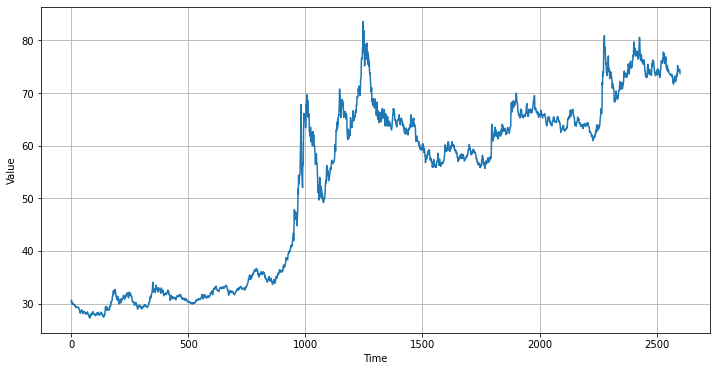

In [37]:
import csv
time_step = []
temps = []

with open('course.csv') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)
    step=0
    for row in reader:
        #print(row)
        temps.append(float(row[1]))
        time_step.append(step)
        step = step + 1
        
temps.reverse()
series = np.array(temps)
time = np.array(time_step)
plt.figure(figsize=(12, 6))
plot_series(time, series)

In [38]:
split_time = 2000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

In [39]:
import tensorflow as tf
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [40]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [41]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(2000,)


/usr/local/lib/python3.9/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/100
8/8 [==============================] - 5s 189ms/step - loss: 56.0945 - mae: 56.5932
Epoch 2/100
8/8 [==============================] - 2s 168ms/step - loss: 51.6471 - mae: 52.1455
Epoch 3/100
8/8 [==============================] - 2s 171ms/step - loss: 50.4545 - mae: 50.9526
Epoch 4/100
8/8 [==============================] - 2s 170ms/step - loss: 48.2266 - mae: 48.7246
Epoch 5/100
8/8 [==============================] - 2s 212ms/step - loss: 45.5725 - mae: 46.0707
Epoch 6/100
8/8 [==============================] - 2s 200ms/step - loss: 42.5655 - mae: 43.0645
Epoch 7/100
8/8 [==============================] - 2s 220ms/step - loss: 39.0516 - mae: 39.5508
Epoch 8/100
8/8 [==============================] - 2s 220ms/step - loss: 34.9496 - mae: 35.4490
Epoch 9/100
8/8 [==============================] - 2s 217ms/step - loss: 30.1568 - mae: 30.6557
Epoch 10/100
8/8 [==============================] - 2s 204ms/step - loss: 25.6287 - mae: 26.1280
Epoch 11/100
8/8 [=====================

8/8 [==============================] - 2s 191ms/step - loss: 7.7474 - mae: 8.2310
Epoch 87/100
8/8 [==============================] - 2s 173ms/step - loss: 30.3599 - mae: 30.8560
Epoch 88/100
8/8 [==============================] - 2s 187ms/step - loss: 32.3805 - mae: 32.8788
Epoch 89/100
8/8 [==============================] - 2s 196ms/step - loss: 30.6930 - mae: 31.1874
Epoch 90/100
8/8 [==============================] - 2s 184ms/step - loss: 20.9059 - mae: 21.4021
Epoch 91/100
8/8 [==============================] - 2s 182ms/step - loss: 34.6505 - mae: 35.1500
Epoch 92/100
8/8 [==============================] - 2s 183ms/step - loss: 21.9789 - mae: 22.4720
Epoch 93/100
8/8 [==============================] - 2s 182ms/step - loss: 39.0826 - mae: 39.5786
Epoch 94/100
8/8 [==============================] - 2s 184ms/step - loss: 35.6425 - mae: 36.1401
Epoch 95/100
8/8 [==============================] - 2s 184ms/step - loss: 18.2738 - mae: 18.7700
Epoch 96/100
8/8 [===========================

(1e-08, 0.0001, 0.0, 60.0)

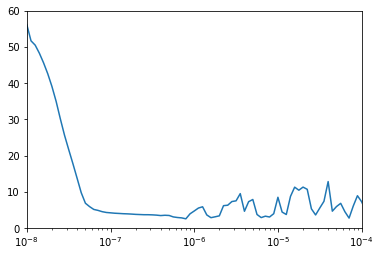

In [42]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [43]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=150)

Epoch 1/150
20/20 [==============================] - 4s 66ms/step - loss: 18.4077 - mae: 18.9009
Epoch 2/150
20/20 [==============================] - 1s 66ms/step - loss: 9.0951 - mae: 9.5875
Epoch 3/150
20/20 [==============================] - 1s 67ms/step - loss: 4.3084 - mae: 4.7823
Epoch 4/150
20/20 [==============================] - 2s 86ms/step - loss: 2.3644 - mae: 2.7919
Epoch 5/150
20/20 [==============================] - 2s 83ms/step - loss: 1.9299 - mae: 2.3291
Epoch 6/150
20/20 [==============================] - 2s 76ms/step - loss: 1.7563 - mae: 2.1402
Epoch 7/150
20/20 [==============================] - 2s 70ms/step - loss: 1.6729 - mae: 2.0516
Epoch 8/150
20/20 [==============================] - 2s 86ms/step - loss: 1.6084 - mae: 1.9865
Epoch 9/150
20/20 [==============================] - 1s 66ms/step - loss: 1.5631 - mae: 1.9425
Epoch 10/150
20/20 [==============================] - 1s 66ms/step - loss: 1.5051 - mae: 1.8830
Epoch 11/150
20/20 [===========================

20/20 [==============================] - 3s 123ms/step - loss: 0.4275 - mae: 0.7235
Epoch 87/150
20/20 [==============================] - 2s 109ms/step - loss: 0.4321 - mae: 0.7333
Epoch 88/150
20/20 [==============================] - 2s 95ms/step - loss: 0.4410 - mae: 0.7479
Epoch 89/150
20/20 [==============================] - 2s 104ms/step - loss: 0.4338 - mae: 0.7370
Epoch 90/150
20/20 [==============================] - 2s 104ms/step - loss: 0.4267 - mae: 0.7259
Epoch 91/150
20/20 [==============================] - 2s 97ms/step - loss: 0.4263 - mae: 0.7270
Epoch 92/150
20/20 [==============================] - 2s 109ms/step - loss: 0.4098 - mae: 0.7017
Epoch 93/150
20/20 [==============================] - 2s 97ms/step - loss: 0.4065 - mae: 0.6970
Epoch 94/150
20/20 [==============================] - 2s 103ms/step - loss: 0.4141 - mae: 0.7109
Epoch 95/150
20/20 [==============================] - 2s 95ms/step - loss: 0.4153 - mae: 0.7146
Epoch 96/150
20/20 [===========================

In [44]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

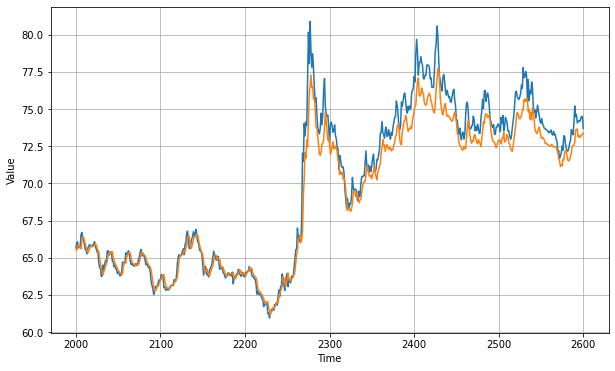

In [45]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [46]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

0.8065808